<a href="https://colab.research.google.com/github/victordibia/taxi/blob/main/notebooks/taxi_model_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install scikit-learn==0.23.2 pandas==1.1.3

In [ ]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm 

In [ ]:
df = pd.read_csv("taxi/data/training.csv")

In [ ]:
categorical_features = ["month","week","hour","isweekday","holiday", "dayofweek", "PULocationID", "DOLocationID"]  #["PULocationID", "DOLocationID"]
feature_list = ["passenger_count","trip_time","fare_amount"]  
numeric_features = ["passenger_count"]
dfa = df  

dfa[categorical_features] = dfa[categorical_features].astype("category") 
df_data = dfa[feature_list + categorical_features] 


In [ ]:

train_sample_size = 300000
df_draw = df_data.sample(train_sample_size, random_state=42)
both_labels = df_draw[["fare_amount", "trip_time"]]
df_draw.drop(["trip_time","fare_amount"], axis =1, inplace=True)
df_draw.head(2) 

,passenger_count,month,week,hour,isweekday,holiday,dayofweek,PULocationID,DOLocationID
158036,1.0,1,1,12,0.0,0,4,138,129
902373,2.0,5,21,14,0.0,0,0,137,137


In [ ]:
categorical_idx = df_draw.columns.get_indexer(categorical_features)
numeric_idx = df_draw.columns.get_indexer(numeric_features)
categorical_idx, numeric_idx

(array([1, 2, 3, 4, 5, 6, 7, 8]), array([0]))

In [ ]:
import time
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor 
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR 
from sklearn.linear_model import LinearRegression

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, mean_squared_error, mean_absolute_error, mean_squared_log_error
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector as selector

num_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])
cat_transformer = Pipeline(steps=[ 
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        # ('num', num_transformer, selector(dtype_include='float64')), 
        ('num', num_transformer, numeric_idx),
        ('cat', cat_transformer, categorical_idx)
        ]) 

#  keep track of all details for models we train
def train_model(model, data, labels): 
  X = data.values 
  y = labels.values 
  X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42) 

  # pipe = Pipeline([('scaler', StandardScaler()),('clf', model["clf"])])
  pipe = Pipeline(steps=[
          ('preprocessor', preprocessor),
          ('clf', model["clf"])])
  start_time = time.time()

  # with joblib.parallel_backend('dask'):
  #   pipe.fit(X_train, y_train)

  pipe.fit(X_train, y_train)  
  train_time = time.time() - start_time

  train_preds = pipe.predict(X_train) 
  test_preds = pipe.predict(X_test)

  np.histogram(train_preds)
  np.histogram(test_preds) 

  train_rmse = np.sqrt(mean_squared_error(y_train, train_preds))
  test_rmse = np.sqrt(mean_squared_error(y_test, test_preds)) 

  train_mae =  mean_absolute_error(y_train, train_preds)
  test_mae =  mean_absolute_error(y_test, test_preds)

  train_accuracy =  pipe.score(X_train, y_train)
  test_accuracy = pipe.score(X_test, y_test) 

  model_details = {"name": model["name"], 
                   "train_rmse":train_rmse, 
                   "test_rmse":test_rmse, 
                   "train_mae":train_mae, 
                   "test_mae":test_mae, 
                   "train_time": train_time, 
                   "model": pipe,
                   "y_test": y_test,
                   "test_preds": test_preds
                   }
  return model_details

models = [  
          {"name": "Random Forest", "clf": RandomForestRegressor(n_estimators=100)},
          # {"name": "Gradient Boosting", "clf": GradientBoostingRegressor(n_estimators=100)}, 
          {"name": "MLP Classifier", "clf": MLPRegressor(solver='adam', alpha=1e-1, hidden_layer_sizes=(20,20,10,5,2), max_iter=500, random_state=42)}
          ]




In [ ]:
def plot_models(trained_models,outcome_type):
  # visualize accuracy and run time
  setup_plot()
  model_df = pd.DataFrame(trained_models)
  model_df.sort_values("test_rmse", inplace=True) 
  ax = model_df[["train_rmse","test_rmse", "name"]].plot(kind="line", x="name", figsize=(19,5), title="Classifier Performance Sorted by Test Accuracy - " + outcome_type)
  ax.legend(["Train RMSE", "Test RMSE"])
  for p in ax.patches:
      ax.annotate( str( round(p.get_height(),3) ), (p.get_x() * 1.005, p.get_height() * 1.005))

  ax.title.set_size(20)
  plt.box(False)

  model_df.sort_values("train_time", inplace=True)
  ax= model_df[["train_time","name"]].plot(kind="line", x="name", figsize=(19,5), grid=True, title="Classifier Training Time (seconds)" + outcome_type)
  ax.title.set_size(20)
  ax.legend(["Train Time"])
  plt.box(False) 


def train_models(models, data, labels, outcome_type):
  trained_models = [] 
  for model in tqdm(models):
    model_details = train_model(model, data, labels) 
    model_details["label"] = outcome_type
    trained_models.append(model_details) 
  
  return trained_models 

%time multi_output_model = train_models(models, df_draw, both_labels, "Trip Time") 


CPU times: user 2h 24min 16s, sys: 11min 15s, total: 2h 35min 31s
Wall time: 2h 23min 19s


In [ ]:
def plot_trained_models(trained_model, title, window_size=100): 

  plt.figure(figsize=(14,5))
  fare = [x[0] for x in trained_model["y_test"][:window_size]]
  triptime = [x[1] for x in trained_model["y_test"][:window_size]]

  fare_preds = [x[0] for x in trained_model["test_preds"][:window_size]]
  triptime_preds = [x[1] for x in trained_model["test_preds"][:window_size]]

  plt.plot(fare , label="Ground Truth") 
  plt.plot(fare_preds , label="Predicitions" ) 
  plt.title("Model Predictions vs Ground Truth | " + trained_model["name"] + " | " + " Fare ")
  plt.legend(loc="upper right")

  plt.figure(figsize=(14,5))
  plt.plot(triptime , label="Ground Truth") 
  plt.plot(triptime_preds , label="Predicitions" ) 
  plt.title("Model Predictions vs Ground Truth | " + trained_model["name"] + " | " + " Time ")
  plt.legend(loc="upper right")

  print("RMSE: Train",trained_model["train_rmse"], "Test",trained_model["test_rmse"]  )
  print("MAE: Train",trained_model["train_mae"], "Test",trained_model["test_mae"]  )



In [ ]:
multi_output_model[0]["test_preds"].shape, multi_output_model[0]["y_test"].shape

((75000, 2), (75000, 2))

RMSE: Train 2.1666768104333944 Test 5.66636779238094
MAE: Train 1.2351001772196655 Test 3.2514253773679975


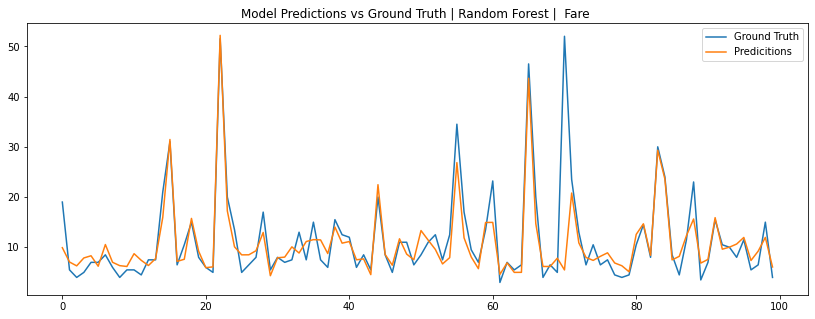

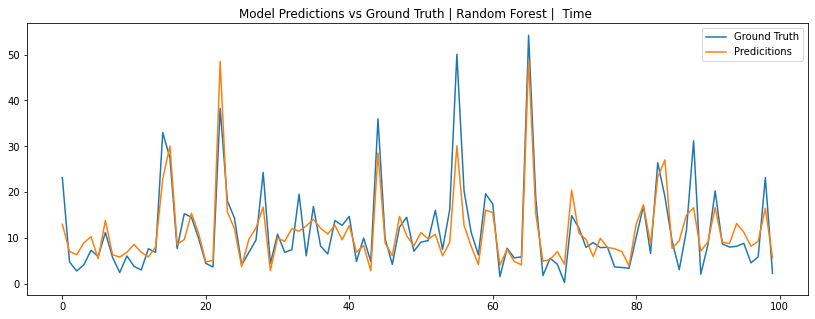

In [ ]:
plot_trained_models(multi_output_model[0], "Trip Time")

RMSE: Train 4.099741150564913 Test 4.650943548821218
MAE: Train 2.368159621435759 Test 2.5597462998426646


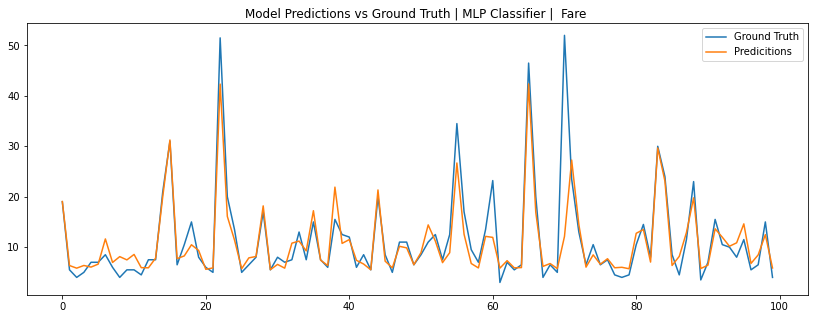

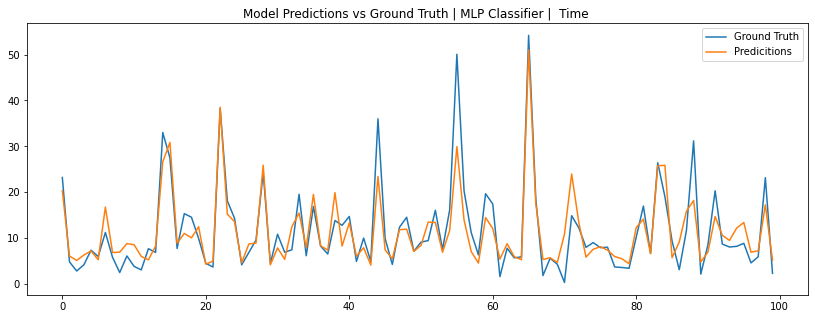

In [ ]:
plot_trained_models(multi_output_model[1], "Trip Time")

In [ ]:
def result_to_df(trained_model, title):
  print("Results for ", title)
  model_df = pd.DataFrame(trained_model)
  return model_df[["name","train_rmse","test_rmse", "train_mae","test_mae"]] 

In [ ]:
result_to_df(multi_output_model, "Trip Fare")

Results for  Trip Fare


,name,train_rmse,test_rmse,train_mae,test_mae
0,Random Forest,2.166677,5.666368,1.23510,3.251425
1,MLP Classifier,4.099741,4.650944,2.36816,2.559746


## Export Model

- Write models to joblib file which can then be used to setup a Cloud AI Platform Model Endpoint.

In [ ]:
!mkdir models 
!mkdir models/mlp
!mkdir models/randomforest
joblib.dump(multi_output_model[0]["model"],"models/randomforest/model.joblib")
joblib.dump(multi_output_model[1]["model"],"models/mlp/model.joblib")
!gsutil -m cp -r models gs://taximodel